In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [2]:
import sys
import os # my addtion

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import torch

from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score


from matplotlib.collections import LineCollection
import pandas as pd
import d_library as dl

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


In [3]:
iterations = 2000

In [57]:
# GET THIS FROM A LIBRARY SCRIPT LATER
def base_embed(input, temp=1, dimension=3, lr = 0.0001, d=0.1):

    
    # build CEBRA time model
    model = CEBRA(model_architecture='offset1-model-mse',
                         batch_size=512,
                         learning_rate=int(lr),
                         temperature=int(temp),
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='euclidean',
                         delta=int(d),
                         conditional='time',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True)

    model.fit(input)
    embedding = model.transform(input)
    return model, embedding

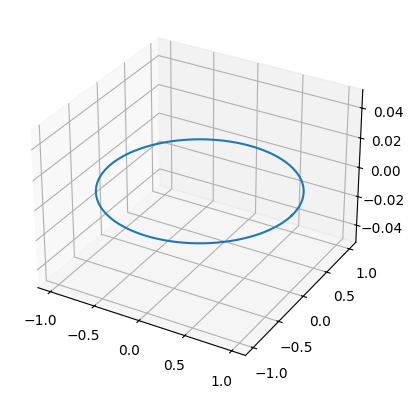

(100, 3)

In [6]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

In [7]:
xyz = dl.make_lorenz()

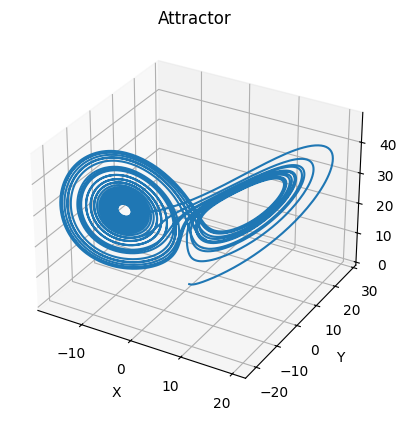

In [8]:
# Plot the Lorenz attractor
dl.plot_lorenz(xyz)

In [9]:
new_lorenz = np.transpose(xyz)

In [60]:
new_lorenz.shape

(10000, 3)

/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_60673/350380364.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(new_lorenz[:,0],


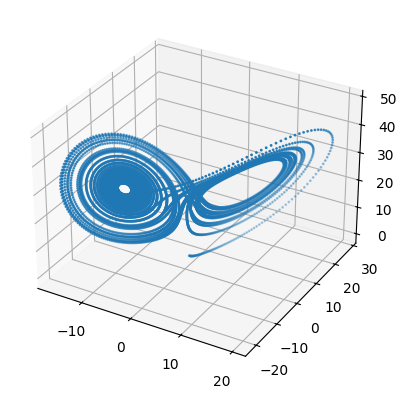

In [62]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(new_lorenz[:,0],
            new_lorenz[:,1],
            new_lorenz[:,2],
            s=1,
            cmap='cool')

In [10]:
# ideal model for circle and lorenz inputs
ideal_model, ideal_embedding = base_embed(input=circle, temp=1, dimension=3, lr = 0.1, d=0.1) 
ideal_model_l, ideal_embedding_l = base_embed(input=new_lorenz, temp=1,dimension=3, lr=0.01, d=1)

pos:  0.0000 neg:  6.2379 total:  6.2379 temperature:  1.0000: 100%|██████████| 2000/2000 [00:19<00:00, 100.48it/s]
pos:  0.0002 neg:  5.8189 total:  5.8192 temperature:  1.0000: 100%|██████████| 2000/2000 [00:18<00:00, 105.80it/s]


In [11]:
ideal_embedding.shape

(100, 3)

In [12]:
cebra.io.reduce(ideal_embedding, ratio=0.99, num_components=3)

array([[ 0.01931149],
       [ 0.01869057],
       [ 0.01798194],
       [ 0.01719717],
       [ 0.01634843],
       [ 0.01544818],
       [ 0.01450898],
       [ 0.01354314],
       [ 0.01256244],
       [ 0.01157793],
       [ 0.01059965],
       [ 0.00963648],
       [ 0.00869593],
       [ 0.00778405],
       [ 0.00690534],
       [ 0.00606274],
       [ 0.0052576 ],
       [ 0.00448978],
       [ 0.00375774],
       [ 0.00305862],
       [ 0.00238846],
       [ 0.00174241],
       [ 0.00111484],
       [ 0.00049967],
       [-0.00010945],
       [-0.0007189 ],
       [-0.00133486],
       [-0.00196311],
       [-0.0026088 ],
       [-0.00327631],
       [-0.0039691 ],
       [-0.00468955],
       [-0.00543892],
       [-0.00621734],
       [-0.0070237 ],
       [-0.00785575],
       [-0.00871013],
       [-0.00958243],
       [-0.01046735],
       [-0.01135874],
       [-0.01224977],
       [-0.01313306],
       [-0.01400076],
       [-0.01484471],
       [-0.01565656],
       [-0

<Axes3D: title={'center': 'Lorenz Attractor'}>

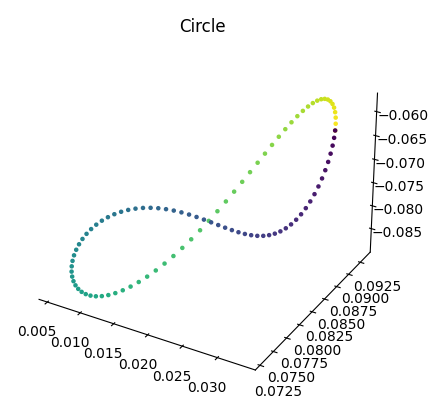

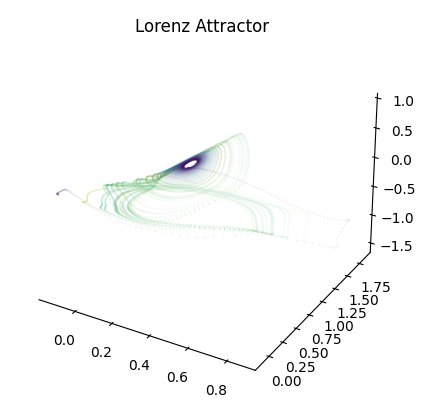

In [13]:
cebra.plot_embedding(ideal_embedding, embedding_labels='time', markersize=5, alpha=1, title='Circle')
cebra.plot_embedding(ideal_embedding_l, embedding_labels='time', markersize=0.001, alpha=1, title='Lorenz Attractor')

Ok, now that we have the outputs of the Models notebook, let's compare the ideal embedding with the top 2 PCs for the Lorenz Attractor. The CEBRA embedding shouldn't be any worse than that

In [14]:
# standardize input to pca
z = StandardScaler().fit_transform(new_lorenz)

Text(0.5, 1.0, 'Lorenz attractor')

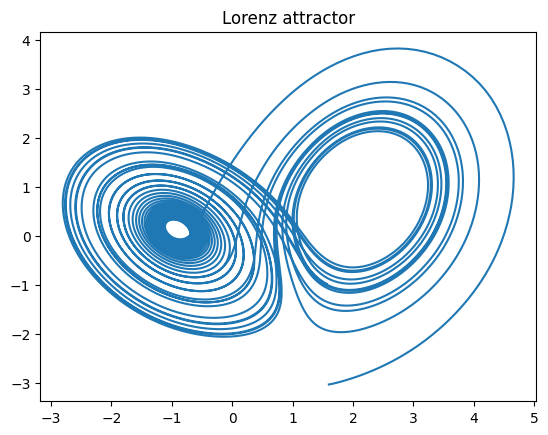

In [17]:
# make a pca model and fit on the object
pca = PCA(n_components=2)

# compute the PCs and get the explained variance
object_pca = pca.fit_transform(z)

plt.plot(object_pca[:,0], object_pca[:,1])
plt.title("Lorenz attractor")


In [26]:
import sklearn.linear_model

def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

In [64]:
# make a function that compares the top 2 PCs and the CEBRA embedding

def pc_cebra_comp(object, n_iterations = 1):
    
    # Check if the input array has shape (n, m)
    assert object.shape[1] == 3 , f"Input array must have shape 3 columns"

    # standardize input data to PCA
    pca_obj = StandardScaler().fit_transform(object)

    # define grid
    fig0 = plt.figure(figsize=(8,4*n_iterations))
    gs = gridspec.GridSpec(n_iterations, 2, figure=fig0)

    # make list to hold the explained variance values
    pca_exp_var = []
    cebra_exp_var = []

    for i in range(0,n_iterations):
        
        # make a pca model and fit on the object
        pca = PCA(n_components=3)

        # compute the PCs and get the explained variance
        object_pca = pca.fit_transform(pca_obj)
        explained_var = pca.explained_variance_ratio_
        pca_exp_var.append(explained_var)

        # compute the cebra embedding using the ideal params learned earlier
        cebra_model, cebra_embedding = base_embed(input=object, temp=0.001,dimension=3, lr=0.01, d=1)
        exp_var_cebra = explained_variance_score(object,cebra_embedding)
        cebra_exp_var.append(exp_var_cebra)

        cebra_score, transformed_embedding = reconstruction_score(cebra_embedding,object)
        
        # make a plot of the 2 PCs of the object
        ax0 = fig0.add_subplot(gs[i,0], projection='3d')
        ax0.scatter(object_pca[:,0], object_pca[:,1],object_pca[:,2], s=0.07)
        ax0.set_title('PCA')

        # plot the cebra embedding
        ax1 = fig0.add_subplot(gs[i,1], projection='3d')         
        cebra.plot_embedding(embedding=transformed_embedding, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title='CEBRA')
        # cebra.plot_embedding(embedding=cebra_embedding, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title='CEBRA')
        print(f"linear reconstruction score: {cebra_score}")
    
    plt.show()



pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|██████████| 2000/2000 [00:19<00:00, 102.51it/s]


linear reconstruction score: 0.783446652223233


pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|██████████| 2000/2000 [00:19<00:00, 104.68it/s]


linear reconstruction score: 0.8328406499930776


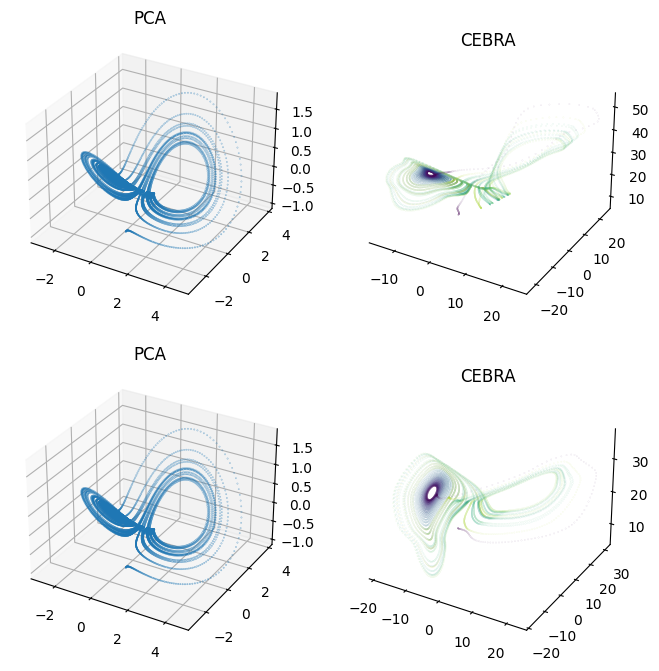

In [65]:
pc_cebra_comp(new_lorenz,2)

In [21]:
# make a pca model and fit on the object
pca_ = PCA(n_components=3)

# compute the PCs and get the explained variance
object_pca = pca_.fit_transform(new_lorenz)

In [23]:
pca_cebra = cebra.io.reduce(new_lorenz, num_components=3)